# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
# # TODO: Install any packages that you might need
# !pip install -U sagemaker

In [7]:
# TODO: Import any packages that you might need
import json
import matplotlib.pyplot as plt
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.huggingface import HuggingFace
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os

In [ ]:
%%capture
!aws s3 sync s3://aft-vbi-pds/ s3://capstone-tannp3/ 

In [21]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:46<00:00, 11.56it/s]


100%|██████████| 2299/2299 [03:18<00:00, 11.58it/s]


100%|██████████| 2666/2666 [03:58<00:00, 11.17it/s]


100%|██████████| 2373/2373 [03:24<00:00, 11.61it/s]


100%|██████████| 1875/1875 [02:36<00:00, 12.00it/s]


## Metadata

In [1]:
!aws s3 cp --no-sign-request s3://aft-vbi-pds/metadata/500.json -

{
    "BIN_FCSKU_DATA": {
        "B00PLKV5H6": {
            "asin": "B00PLKV5H6",
            "height": {
                "unit": "IN",
                "value": 6.799999999999999
            },
            "length": {
                "unit": "IN",
                "value": 7.0
            },
            "name": "HBD Thermoid NBR/PVC SAE30R6 Fuel Line Hose, 5/16\" x 25' Length, 0.3125\" ID, Black",
            "quantity": 1,
            "weight": {
                "unit": "pounds",
                "value": 3.0
            },
            "width": {
                "unit": "IN",
                "value": 7.0
            }
        },
        "B00WTI3SGO": {
            "asin": "B00WTI3SGO",
            "height": {
                "unit": "IN",
                "value": 1.2
            },
            "length": {
                "unit": "IN",
                "value": 7.6
            },
            "name": "The Witcher 3: Wild Hunt - PC",
            "quantity": 1,
            "weight": {
    

In [2]:
!aws s3 ls --no-sign-request s3://aft-vbi-pds/metadata/ --summarize > metadatalist

In [5]:
!tail metadatalist

2017-01-14 01:59:16       4529 99993.json
2017-01-14 01:59:16       4529 99994.json
2017-01-14 01:59:16       3740 99995.json
2017-01-14 01:59:16        864 99996.json
2017-01-14 01:59:16       2132 99997.json
2017-01-14 01:59:16       2770 99998.json
2017-01-14 01:59:16       1658 99999.json

Total Objects: 536435
   Total Size: 1098414519


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

The dataset has 536,435 JPEG files in total in alignment with metadata files. Due to file naming rules, they can be divided into three categories:

- 1~4 digit: ```1.jpg``` ~ ```1200.jpg```: 1200
- 5-digit: ```00001.jpg``` ~ ```99999.jpg```: 99,999
- 6-digit: ```100000.jpg``` ~ ```535234.jpg```: 435,235

Furthermore, the capstone repository provides us with a chosen subset of the dataset, ```file_list.json```. We'll investigate that later.

In [10]:
#TODO: Perform any data cleaning or data preprocessing
with open("file_list.json", "r") as f:
    file_list = json.load(f)

In [13]:
len_classes = [len(i) for i in file_list.values()]

In [14]:
len_classes

[1228, 2299, 2666, 2373, 1875]

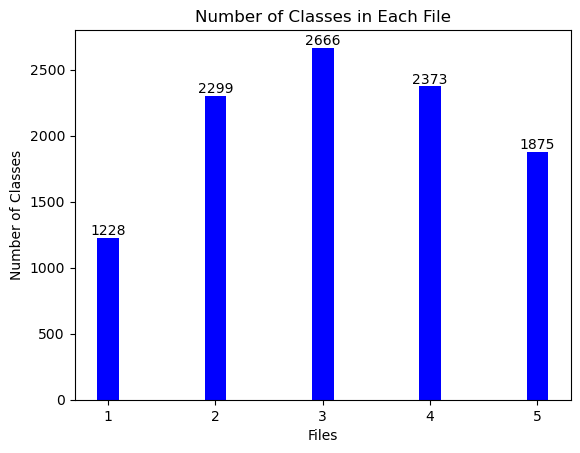

In [19]:
plt.bar(file_list.keys(), len_classes, 0.2, color='b')

plt.xlabel('Files')
plt.ylabel('Number of Classes')
plt.title('Number of Classes in Each File')

# Add text annotations above each bar
for i, len_class in enumerate(len_classes):
    plt.text(i, len_class + 0.2, str(len_class), ha='center', va='bottom', fontsize=10)

In [ ]:
#TODO: Upload the data to AWS S3

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [2]:
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

In [3]:
sess.default_bucket()

'sagemaker-us-east-1-379150537365'

In [8]:
#TODO: Create your training estimator
from sagemaker.huggingface import HuggingFace
import time

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 5,                          # number of training epochs
                 'train_batch_size': 32,               # batch size for training
                 'eval_batch_size': 64,                # batch size for evaluation
                 'learning_rate': 5e-5,                # learning rate used during training
                 'model_id':'microsoft/beit-base-patch16-224', # pre-trained model
                 'warmup_ratio': 0.1
                 }

In [9]:
metric_definitions=[
    {'Name': 'eval_loss',               'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy',           'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1',                 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision',          'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"}]

In [19]:
# define Training Job Name 
job_name = f'huggingface-beit-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'

# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'train.py',        # fine-tuning script used in training jon
    instance_type        = 'ml.g4dn.xlarge',   # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    base_job_name        = job_name,          # the name of the training job
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    transformers_version = '4.28',             # the transformers version used in the training job
    pytorch_version      = '2.0',             # the pytorch_version version used in the training job
    py_version           = 'py310',            # the python version used in the training job
    hyperparameters      = hyperparameters,   # the hyperparameter used for running the training job
    metric_definitions   = metric_definitions # the metrics regex definitions to extract logs
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [20]:
training_data = {
    'train': "s3://dataset-capstone/"
}

# starting the train job with our uploaded datasets as input
huggingface_estimator.fit(training_data, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-workshop-2023-08-27-09-45-4-2023-08-27-09-45-48-519


Using provided s3_resource
2023-08-27 09:45:49 Starting - Starting the training job...
2023-08-27 09:46:04 Starting - Preparing the instances for training......
2023-08-27 09:47:05 Downloading - Downloading input data...
2023-08-27 09:47:42 Training - Downloading the training image....................................
2023-08-27 09:53:49 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-27 09:54:03,379 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-27 09:54:03,401 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-27 09:54:03,414 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-27 09:54:03,424 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-08-27 09:54:06,373 sagemaker-trai

In [21]:
huggingface_estimator.model_data

's3://sagemaker-us-east-1-379150537365/huggingface-workshop-2023-08-27-09-45-4-2023-08-27-09-45-48-519/output/model.tar.gz'

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [22]:
#TODO: Create your hyperparameter search space
hyperparameter_ranges = {
    "train_batch_size": CategoricalParameter([16, 32, 64]),
    "epochs": IntegerParameter(3, 6),
    "learning_rate": ContinuousParameter(5e-6, 5e-4)
}

In [24]:
#TODO: Create your training estimator
objective_metric_name = "eval_f1"
objective_type = "Maximize"
metric_definitions=[{'Name': 'eval_f1',                 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"}]

In [25]:
# TODO: Fit your estimator
import time
job_name = f'huggingface-beit-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'

huggingface_estimator = HuggingFace(
    entry_point          = 'train.py',        # fine-tuning script used in training jon
    instance_type        = 'ml.g4dn.xlarge',   # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    base_job_name        = job_name,          # the name of the training job
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    transformers_version = '4.28',             # the transformers version used in the training job
    pytorch_version      = '2.0',             # the pytorch_version version used in the training job
    py_version           = 'py310',            # the python version used in the training job
    metric_definitions   = metric_definitions # the metrics regex definitions to extract logs
)

In [26]:
tuner = HyperparameterTuner(
    estimator = huggingface_estimator,
    early_stopping_type = "Auto",
    metric_definitions = metric_definitions,
    objective_metric_name = objective_metric_name,
    objective_type = objective_type,
    max_jobs = 3,
    max_parallel_jobs = 2,
    hyperparameter_ranges = hyperparameter_ranges
)

In [27]:
training_data = {
    'train': "s3://dataset-capstone/"
}

# starting the train job with our uploaded datasets as input
tuner.fit(training_data, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [28]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2023-08-28 08:57:43 Starting - Preparing the instances for training
2023-08-28 08:57:43 Downloading - Downloading input data
2023-08-28 08:57:43 Training - Training image download completed. Training in progress.
2023-08-28 08:57:43 Uploading - Uploading generated training model
2023-08-28 08:57:43 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"eval_f1"',
 'epochs': '6',
 'learning_rate': '6.301966492587569e-05',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"HuggingFace"',
 'sagemaker_estimator_module': '"sagemaker.huggingface.estimator"',
 'sagemaker_job_name': '"huggingface-beit-2023-08-28-06-48-48-2023-08-28-06-48-50-561"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-379150537365/huggingface-beit-2023-08-28-06-48-48-2023-08-28-06-48-50-561/source/sourcedir.tar.gz"',
 'train_batch_size': '"16"'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances